# Benchmarking pipeline

Biological activities can be estimated by coupling a statistical method with a prior knowledge network. However, it is not clear which method or network performs better. When perturbation experiments are available, one can benchmark these methods by evaluating how good are they at recovering perturbed regulators. In our original `decoupler` [publication](https://doi.org/10.1093/bioadv/vbac016), we observed that `wsum`, `mlm`, `ulm` and `consensus` where the top performer methods. 

In this notebook we showcase how to use `decoupler` for the benchmarking of methods and prior knowledge networks. The data used here consist of single-gene perturbation experiments from the [KnockTF2](http://www.licpathway.net/KnockTFv2/index.php) database, an extensive dataset of literature curated perturbation experiments. If you use these data for your resarch, please cite the original publication of the resource:

>Chenchen Feng, Chao Song, Yuejuan Liu, Fengcui Qian, Yu Gao, Ziyu Ning, Qiuyu Wang, Yong Jiang, Yanyu Li, Meng Li, Jiaxin Chen, Jian Zhang, Chunquan Li, KnockTF: a comprehensive human gene expression profile database with knockdown/knockout of transcription factors, Nucleic Acids Research, Volume 48, Issue D1, 08 January 2020, Pages D93–D100, https://doi.org/10.1093/nar/gkz881

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>

## Loading packages

First, we need to load the relevant packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import decoupler as dc

## Loading the data

We can download the data easily from Zenodo:

In [2]:
!wget 'https://zenodo.org/record/7035528/files/knockTF_expr.csv?download=1' -O knockTF_expr.csv
!wget 'https://zenodo.org/record/7035528/files/knockTF_meta.csv?download=1' -O knockTF_meta.csv

--2024-10-20 09:07:06--  https://zenodo.org/record/7035528/files/knockTF_expr.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/7035528/files/knockTF_expr.csv [following]
--2024-10-20 09:07:07--  https://zenodo.org/records/7035528/files/knockTF_expr.csv
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 146086808 (139M) [text/plain]
Saving to: ‘knockTF_expr.csv’

knockTF_expr.csv    100%[===================>] 139.32M  10.7MB/s    in 14s     

2024-10-20 09:07:21 (9.84 MB/s) - ‘knockTF_expr.csv’ saved [146086808/146086808]

--2024-10-20 09:07:22--  https://zenodo.org/record/7035528/files/knockTF_meta.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238
Connecting to zenodo.org (zenodo.org)|1

We can then read it using `pandas`:

In [3]:
# Read data
mat = pd.read_csv('knockTF_expr.csv', index_col=0)
obs = pd.read_csv('knockTF_meta.csv', index_col=0)

`mat` consist of a matrix of logFCs between the perturbed and the control samples. Positive values mean that these genes were
overexpressed after the perturbation, negative values mean the opposite.

In [4]:
mat

,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AA06,AAA1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
DataSet_01_001,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.00000,0.00000,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,-0.033220,-0.046900,-0.143830,0.00000
DataSet_01_002,-0.173750,0.000000,-0.537790,-0.4424,-1.596640,-0.00010,-0.08260,-3.64590,0.0,0.0,...,0.000000,0.39579,0.000000,0.086110,0.28574,-0.130210,-0.276640,-0.881580,0.812950,0.47896
DataSet_01_003,-0.216130,0.000000,-0.220270,-0.0008,0.000000,0.15580,-0.35802,-0.32025,0.0,0.0,...,0.000000,-0.82964,0.000000,0.064470,0.59323,0.313950,-0.232600,0.065510,-0.147140,0.00000
DataSet_01_004,-0.255680,0.111050,-0.285270,0.0000,-0.035860,-0.46970,0.18559,-0.25601,0.0,0.0,...,0.000000,-0.39888,0.000000,0.104440,-0.16434,0.191460,0.415610,0.393840,0.127900,0.00000
DataSet_01_005,0.478500,-0.375710,-0.847180,0.0000,3.354450,0.17104,-0.34852,-0.95517,0.0,0.0,...,0.000000,0.24849,0.000000,-0.286920,-0.01815,0.119410,0.077850,0.234740,0.228690,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DataSet_04_039,0.668721,0.000000,0.120893,0.0000,0.263564,0.00000,0.00000,0.00000,0.0,0.0,...,-0.324808,0.00000,-0.370491,0.092874,0.00000,0.014075,-0.215169,0.141374,-0.076054,0.00000
DataSet_04_040,1.816027,0.000000,0.139721,0.0000,0.459498,0.00000,0.00000,0.00000,0.0,0.0,...,-0.321726,0.00000,-0.144934,-0.238343,0.00000,-0.134995,0.577406,0.082028,-0.171424,0.00000
DataSet_04_041,-0.174250,0.000000,-0.084499,0.0000,0.112492,0.00000,0.00000,0.00000,0.0,0.0,...,0.405369,0.00000,0.272526,-0.125475,0.00000,0.019763,-0.098584,0.072675,0.199813,0.00000
DataSet_04_042,0.976681,0.000000,0.099845,0.0000,0.366973,0.00000,0.00000,0.00000,0.0,0.0,...,0.397698,0.00000,-0.398350,0.037134,0.00000,0.409704,-0.056978,0.308122,-0.058794,0.00000


On the other hand, `obs` contains the meta-data information of each perturbation experiment.
Here one can find which TF was perturbed (`TF` column), and many other useful information.

In [5]:
obs

,TF,Species,Knock.Method,Biosample.Name,Profile.ID,Platform,TF.Class,TF.Superclass,Tissue.Type,Biosample.Type,Data.Source,Pubmed.ID,logFC
DataSet_01_001,ESR1,Homo sapiens,siRNA,MCF7,GSE10061,GPL3921,Nuclear receptors with C4 zinc fingers,Zinc-coordinating DNA-binding domains,Mammary_gland,Cell line,GEO,18631401,-0.713850
DataSet_01_002,HNF1A,Homo sapiens,shRNA,HuH7,GSE103128,GPL18180,Homeo domain factors,Helix-turn-helix domains,Liver,Cell line,GEO,29466992,0.164280
DataSet_01_003,MLXIP,Homo sapiens,shRNA,HA1ER,GSE11242,GPL4133,Basic helix-loop-helix factors (bHLH),Basic domains,Embryo_kidney,Stem cell,GEO,18458340,0.262150
DataSet_01_004,CREB1,Homo sapiens,shRNA,K562,GSE12056,GPL570,Basic leucine zipper factors (bZIP),Basic domains,Haematopoietic_and_lymphoid_tissue,Cell line,GEO,18801183,-0.950180
DataSet_01_005,POU5F1,Homo sapiens,siRNA,GBS6,GSE12320,GPL570,Homeo domain factors,Helix-turn-helix domains,Bone_marrow,Cell line,GEO,20203285,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
DataSet_04_039,SRPK2,Homo sapiens,CRISPR,HepG2,ENCSR929EIP,-,Others,ENCODE_TF,Liver,Cell line,ENCODE,22955616,-1.392551
DataSet_04_040,WRN,Homo sapiens,shRNA,HepG2,ENCSR093FHC,-,Others,ENCODE_TF,Liver,Cell line,ENCODE,22955616,-0.173964
DataSet_04_041,YBX1,Homo sapiens,CRISPR,HepG2,ENCSR548OTL,-,Cold-shock domain factors,beta-Barrel DNA-binding domains,Liver,Cell line,ENCODE,22955616,-2.025170
DataSet_04_042,ZC3H8,Homo sapiens,shRNA,HepG2,ENCSR184YDW,-,C3H zinc finger factors,Zinc-coordinating DNA-binding domains,Liver,Cell line,ENCODE,22955616,-0.027152


## Filtering

Since some of the experiments collected inside KnockTF are of low quality, it is best to remove them. We can do this by filtering
perturbation experiments where the knocked TF does not show a strong negative logFC (meaning that the knock method did not work).


In [6]:
# Filter out low quality experiments (positive logFCs in knockout experiments)
msk = obs['logFC'] < -1
mat = mat[msk]
obs = obs[msk]
mat.shape, obs.shape

((388, 21985), (388, 13))

## Evaluation

### Single network

As an example, we will evaluate the gene regulatory network
[CollecTRI](https://github.com/saezlab/CollecTRI), for more information you can visit this
[other vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html).

We can retrieve this network by running:

In [7]:
# Get collectri
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


We will run the benchmark pipeline using the top performer methods from `decoupler`. If we would like, we could use any other,
and we can optionaly change their parametters too (for more information check the `decouple` function).

To run the benchmark pipeline, we need input molecular data (`mat`), its associated metadata (`obs`) with the name of the
column where the perturbed regulators are (`perturb`), and which direction the pertrubations are (`sign`, positive or negative).

<div class="alert alert-info">

**Note**
    
Note that if you want to ignore missing values in the input `mat` (denoted as zeros), you can add the parameter `'dense': True` to `decouple_kws`.

</div>

In [8]:
# Example on how to set up decouple arguments
decouple_kws={
    'methods' : ['wsum', 'ulm', 'mlm'],
    'consensus': True,
    'args' : {
        'wsum' : {'times': 100}
    }
}

# Run benchmark pipeline
df = dc.benchmark(mat, obs, collectri, perturb='TF', sign=-1, verbose=True, decouple_kws=decouple_kws)

Extracting inputs...
Formating net...
Removed 109 experiments without sources in net.
Running 279 experiments for 155 unique sources.
Running methods...
52 features of mat are empty, they will be removed.
Running wsum on mat with 279 samples and 21933 targets for 766 sources.
52 features of mat are empty, they will be removed.
Running ulm on mat with 279 samples and 21933 targets for 766 sources.
52 features of mat are empty, they will be removed.
Running mlm on mat with 279 samples and 21933 targets for 766 sources.
Calculating metrics...
Computing metrics...
Done.


The result of running the pipeline is a long-format dataframe containing different performance metrics across methods:

- `auroc`: Area Under the Receiver Operating characteristic Curve (AUROC)
- `auprc`: Area Under the Precision-Recall Curve (AUPRC), which by default uses a calibrated version where 0.5 indicates a random classifier (adapted from [this publication](https://doi.org/10.1007/978-3-030-44584-3_36)).
- `mauroc`: Monte-Carlo Area Under the Precision-Recall Curve (AUPRC)
- `mauprc`: Monte-Carlo Area Under the Receiver Operating characteristic Curve (AUROC)
- `rank`: Rank of the perturbed source per experiment.
- `nrank`: Normalized rank of the perturbed source per experiment (close to 0 is better).

The Monte-Carlo metrics perform random permutations where each one samples the same number of true positives and true negatives to have balanced sets, returning one value per iteration done (10k by default).

In [9]:
df

,groupby,group,source,method,metric,score,ci
0,None,None,None,wsum_estimate,auroc,0.713571,0.001305
1,None,None,None,wsum_estimate,auprc,0.738849,0.001305
2,None,None,None,wsum_estimate,mcauroc,0.717372,0.001305
3,None,None,None,wsum_estimate,mcauroc,0.731504,0.001305
4,None,None,None,wsum_estimate,mcauroc,0.713069,0.001305
...,...,...,...,...,...,...,...
15361,None,None,None,consensus_estimate,nrank,0.278431,NaN
15362,None,None,None,consensus_estimate,nrank,0.515033,NaN
15363,None,None,None,consensus_estimate,nrank,0.228758,NaN
15364,None,None,None,consensus_estimate,nrank,0.027451,NaN


We can easily visualize the results in a scatterplot: 

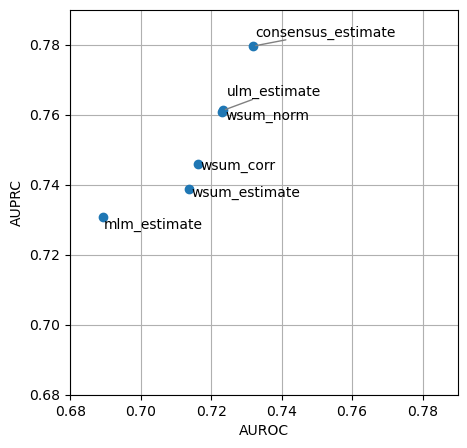

In [10]:
dc.plot_metrics_scatter(df, x='auroc', y='auprc')

It looks like `mlm` this time had worse performance than other methods like `ulm` at recovering
perturbed regulators, this might be caused because there are many TFs that share too many targets.
Whenever there are multiple sources (TFs) and they share a lot of targets we recommend to use `ulm`.
On the other hand, when there are few sources and they are orthogonal (they share few targets), we recommend to use `mlm`.
Since `consensus` remains one of the top performer methods we also recommend its use but at a higher computational cost and less interpretability.

We can also visualise the distirbutions of the obtained metrics, for example `mcauroc`, `mcauprc`, `rank` and `nrank`:

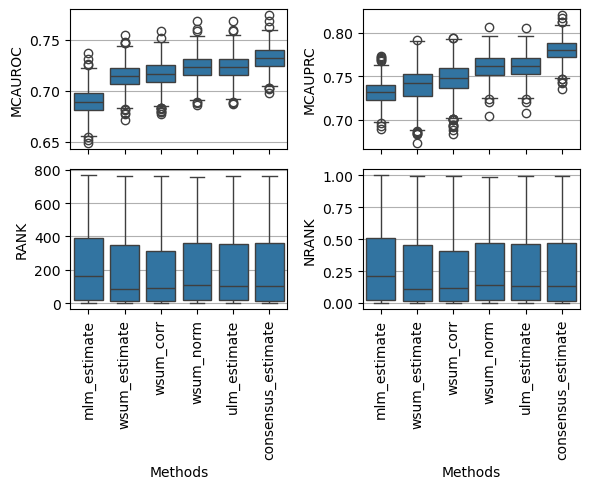

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5), sharex=True, tight_layout=True)
dc.plot_metrics_boxplot(df, metric='mcauroc', ax=axes[0, 0])
dc.plot_metrics_boxplot(df, metric='mcauprc', ax=axes[0, 1])
dc.plot_metrics_boxplot(df, metric='rank', ax=axes[1, 0])
dc.plot_metrics_boxplot(df, metric='nrank', ax=axes[1, 1])

### Multiple networks

This pipeline can evaluate multiple networks at the same time. Now we will evaluate CollecTRI and
[DoRothEA](https://saezlab.github.io/dorothea/), a literature-based network that we developed in the past.
We will also add a randomized version as control.

In [12]:
# Get dorothea
dorothea = dc.get_dorothea(organism='human')

# Randomize nets
ctri_rand = dc.shuffle_net(collectri, target='target', weight='weight').drop_duplicates(['source', 'target'])
doro_rand = dc.shuffle_net(dorothea, target='target', weight='weight').drop_duplicates(['source', 'target'])

We can run the same pipeline but now using a dictionary of networks (and of extra arguments if needed).

In [13]:
# Build dictionary of networks to test
nets = {
    'r_collectri': ctri_rand,
    'r_dorothea': doro_rand,
    'collectri': collectri,
    'dorothea': dorothea,
}

# Example extra arguments
decouple_kws = {
    'r_collectri': {
        'methods' : ['ulm', 'mlm'],
        'consensus': True
    },
    'r_dorothea': {
        'methods' : ['ulm', 'mlm'],
        'consensus': True
    },
    'collectri': {
        'methods' : ['ulm', 'mlm'],
        'consensus': True
    },
    'dorothea': {
        'methods' : ['ulm', 'mlm'],
        'consensus': True
    }
}

# Run benchmark pipeline
df = dc.benchmark(mat, obs, nets, perturb='TF', sign=-1, verbose=True, decouple_kws=decouple_kws)

Using r_collectri network...
Extracting inputs...
Formating net...
Removed 109 experiments without sources in net.
Running 279 experiments for 155 unique sources.
Running methods...
52 features of mat are empty, they will be removed.
Running ulm on mat with 279 samples and 21933 targets for 762 sources.
52 features of mat are empty, they will be removed.
Running mlm on mat with 279 samples and 21933 targets for 762 sources.
Calculating metrics...
Computing metrics...
Done.
Using r_dorothea network...
Extracting inputs...
Formating net...
Removed 175 experiments without sources in net.
Running 213 experiments for 104 unique sources.
Running methods...
55 features of mat are empty, they will be removed.
Running ulm on mat with 213 samples and 21930 targets for 295 sources.
55 features of mat are empty, they will be removed.
Running mlm on mat with 213 samples and 21930 targets for 295 sources.
Calculating metrics...
Computing metrics...
Done.
Using collectri network...
Extracting inputs.

Like before we can try to visualize the results in a scatterplot, this time grouping by the network used:

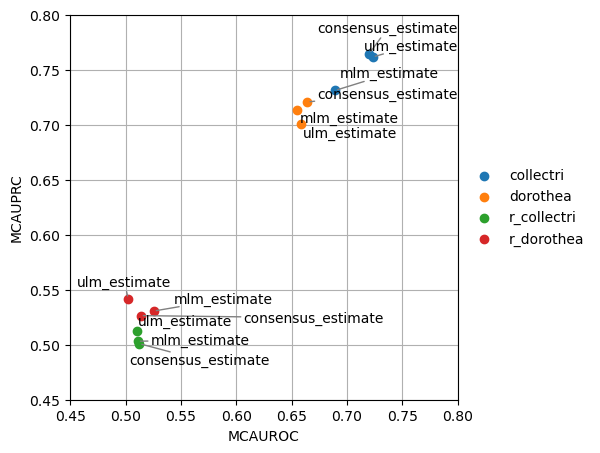

In [14]:
dc.plot_metrics_scatter(df, groupby='net', x='mcauroc', y='mcauprc')

Since this plot is too crowded, we can plot it again separating the methods by columns:

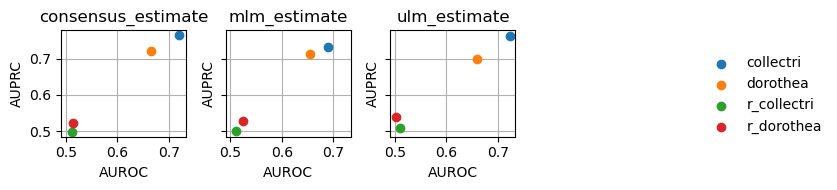

In [15]:
dc.plot_metrics_scatter_cols(df, col='method', x='auroc', y='auprc', figsize=(7, 2), groupby='net')

Or by selecting only one of the methods, in this case `consensus`:

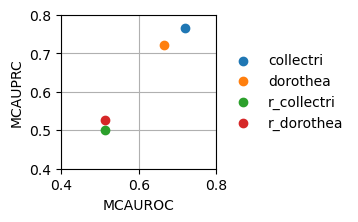

In [16]:
dc.plot_metrics_scatter(df[df['method'] == 'consensus_estimate'], groupby='net', x='mcauroc', y='mcauprc', show_text=False, figsize=(2, 2))

As expected, the random network has a performance close to 0.5 while the rest show higher predictive performance. As previously reported, the collectri network has better performance than dorothea.

If needed, we can also plot the distributions of the Monte-Carlo metrics, now grouped by network:

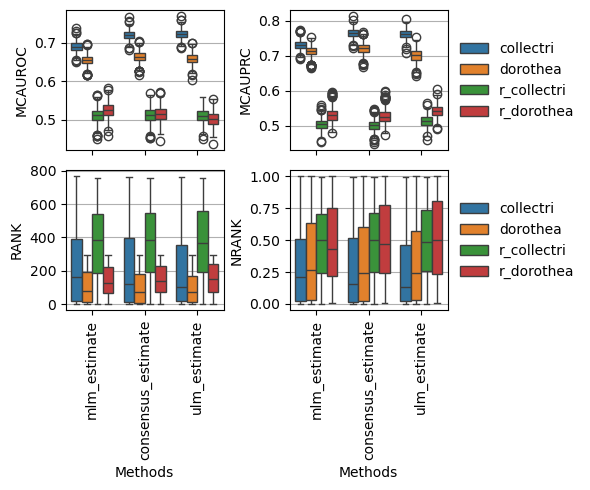

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5), sharex=True, tight_layout=True)
dc.plot_metrics_boxplot(df, metric='mcauroc', groupby='net', ax=axes[0, 0], legend=False)
dc.plot_metrics_boxplot(df, metric='mcauprc', groupby='net', ax=axes[0, 1], legend=True)
dc.plot_metrics_boxplot(df, metric='rank', groupby='net', ax=axes[1, 0], legend=False)
dc.plot_metrics_boxplot(df, metric='nrank', groupby='net', ax=axes[1, 1])

### By source

The benchmark pipeline also allows to test the performance of individual regulators using the argument `by='source'`. For simplicity let us just use the best performing network:

In [18]:
# Example on how to set up decouple arguments
decouple_kws={
    'methods' : ['ulm', 'mlm'],
    'consensus': True,
}

# Run benchmark pipeline
df = dc.benchmark(mat, obs, collectri, perturb='TF', sign=-1, by='source', verbose=True, decouple_kws=decouple_kws)

Extracting inputs...
Formating net...
Removed 109 experiments without sources in net.
Running 279 experiments for 155 unique sources.
Running methods...
52 features of mat are empty, they will be removed.
Running ulm on mat with 279 samples and 21933 targets for 766 sources.
52 features of mat are empty, they will be removed.
Running mlm on mat with 279 samples and 21933 targets for 766 sources.
Calculating metrics...
Computing metrics...
Done.


We can plot the results with:

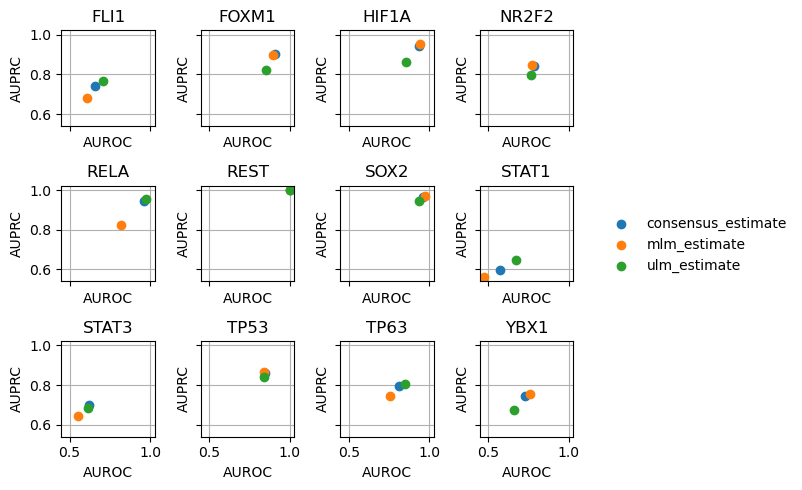

In [19]:
dc.plot_metrics_scatter_cols(df, col='source', figsize=(6, 5), groupby='method')

It looks like we get good predictions for HIF1A, RELA and SOX2 among others. On the other side, we worse predictions for STAT1.

### By meta-data groups

The benchmarking pipeline can also be run by grouping the input experiments using the `groupby` argument. Multiple groups can be selected at the same time but for simplicity, we will just test which knockout method seems to perform the best inhibitions:

In [20]:
# Example on how to set up decouple arguments
decouple_kws={
    'methods' : ['ulm', 'mlm'],
    'consensus': True,
}

# Run benchmark pipeline
df = dc.benchmark(mat, obs, collectri, perturb='TF', sign=-1, groupby='Knock.Method', verbose=True, decouple_kws=decouple_kws)

Extracting inputs...
Formating net...
Removed 109 experiments without sources in net.
Running 279 experiments for 155 unique sources.
Running methods...
52 features of mat are empty, they will be removed.
Running ulm on mat with 279 samples and 21933 targets for 766 sources.
52 features of mat are empty, they will be removed.
Running mlm on mat with 279 samples and 21933 targets for 766 sources.
Calculating metrics...
Computing metrics for groupby Knock.Method...
Done.


Again, we can visualize the results in a collection of scatterplots:

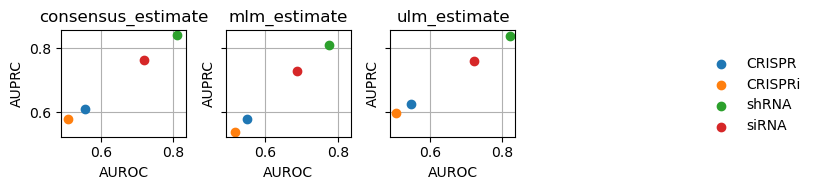

In [21]:
dc.plot_metrics_scatter_cols(df, col='method', figsize=(7, 2), groupby='group')

From our limited data-set, we can see that apparently shRNA works better than other knockout protocols.